## Optimización de hiperparámetros con curvas de aprendizaje y curvas ROC

Scikit-Learn provee varias funciones para cargar datasets y también para generar datasets. Se usará el Breast Cancer Wisconsin (diagnostic) dataset.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

Notar que `data` es un `diccionario`, por lo tanto se procede a convertirlo en un `DataFrame` de Pandas.

In [20]:
df = pd.DataFrame(np.c_[data['data'], data['target']],
                  columns= np.append(data['feature_names'], ['target']))

In [21]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


### EDA corto

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

### Cantidad de datos positivos y negativos

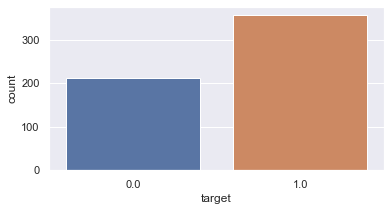

In [23]:
plt.figure(figsize=(6,3))
sns.countplot(df['target'],label="Count")
plt.show()

Para facilitar el análisis, se selecciona las columnas donde los nombres de los atributos comiencen con `mean`.

In [24]:
features_mean = list(df.columns[0:10])
features_mean

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension']

In [25]:
df = df[features_mean + ['target']]
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.0


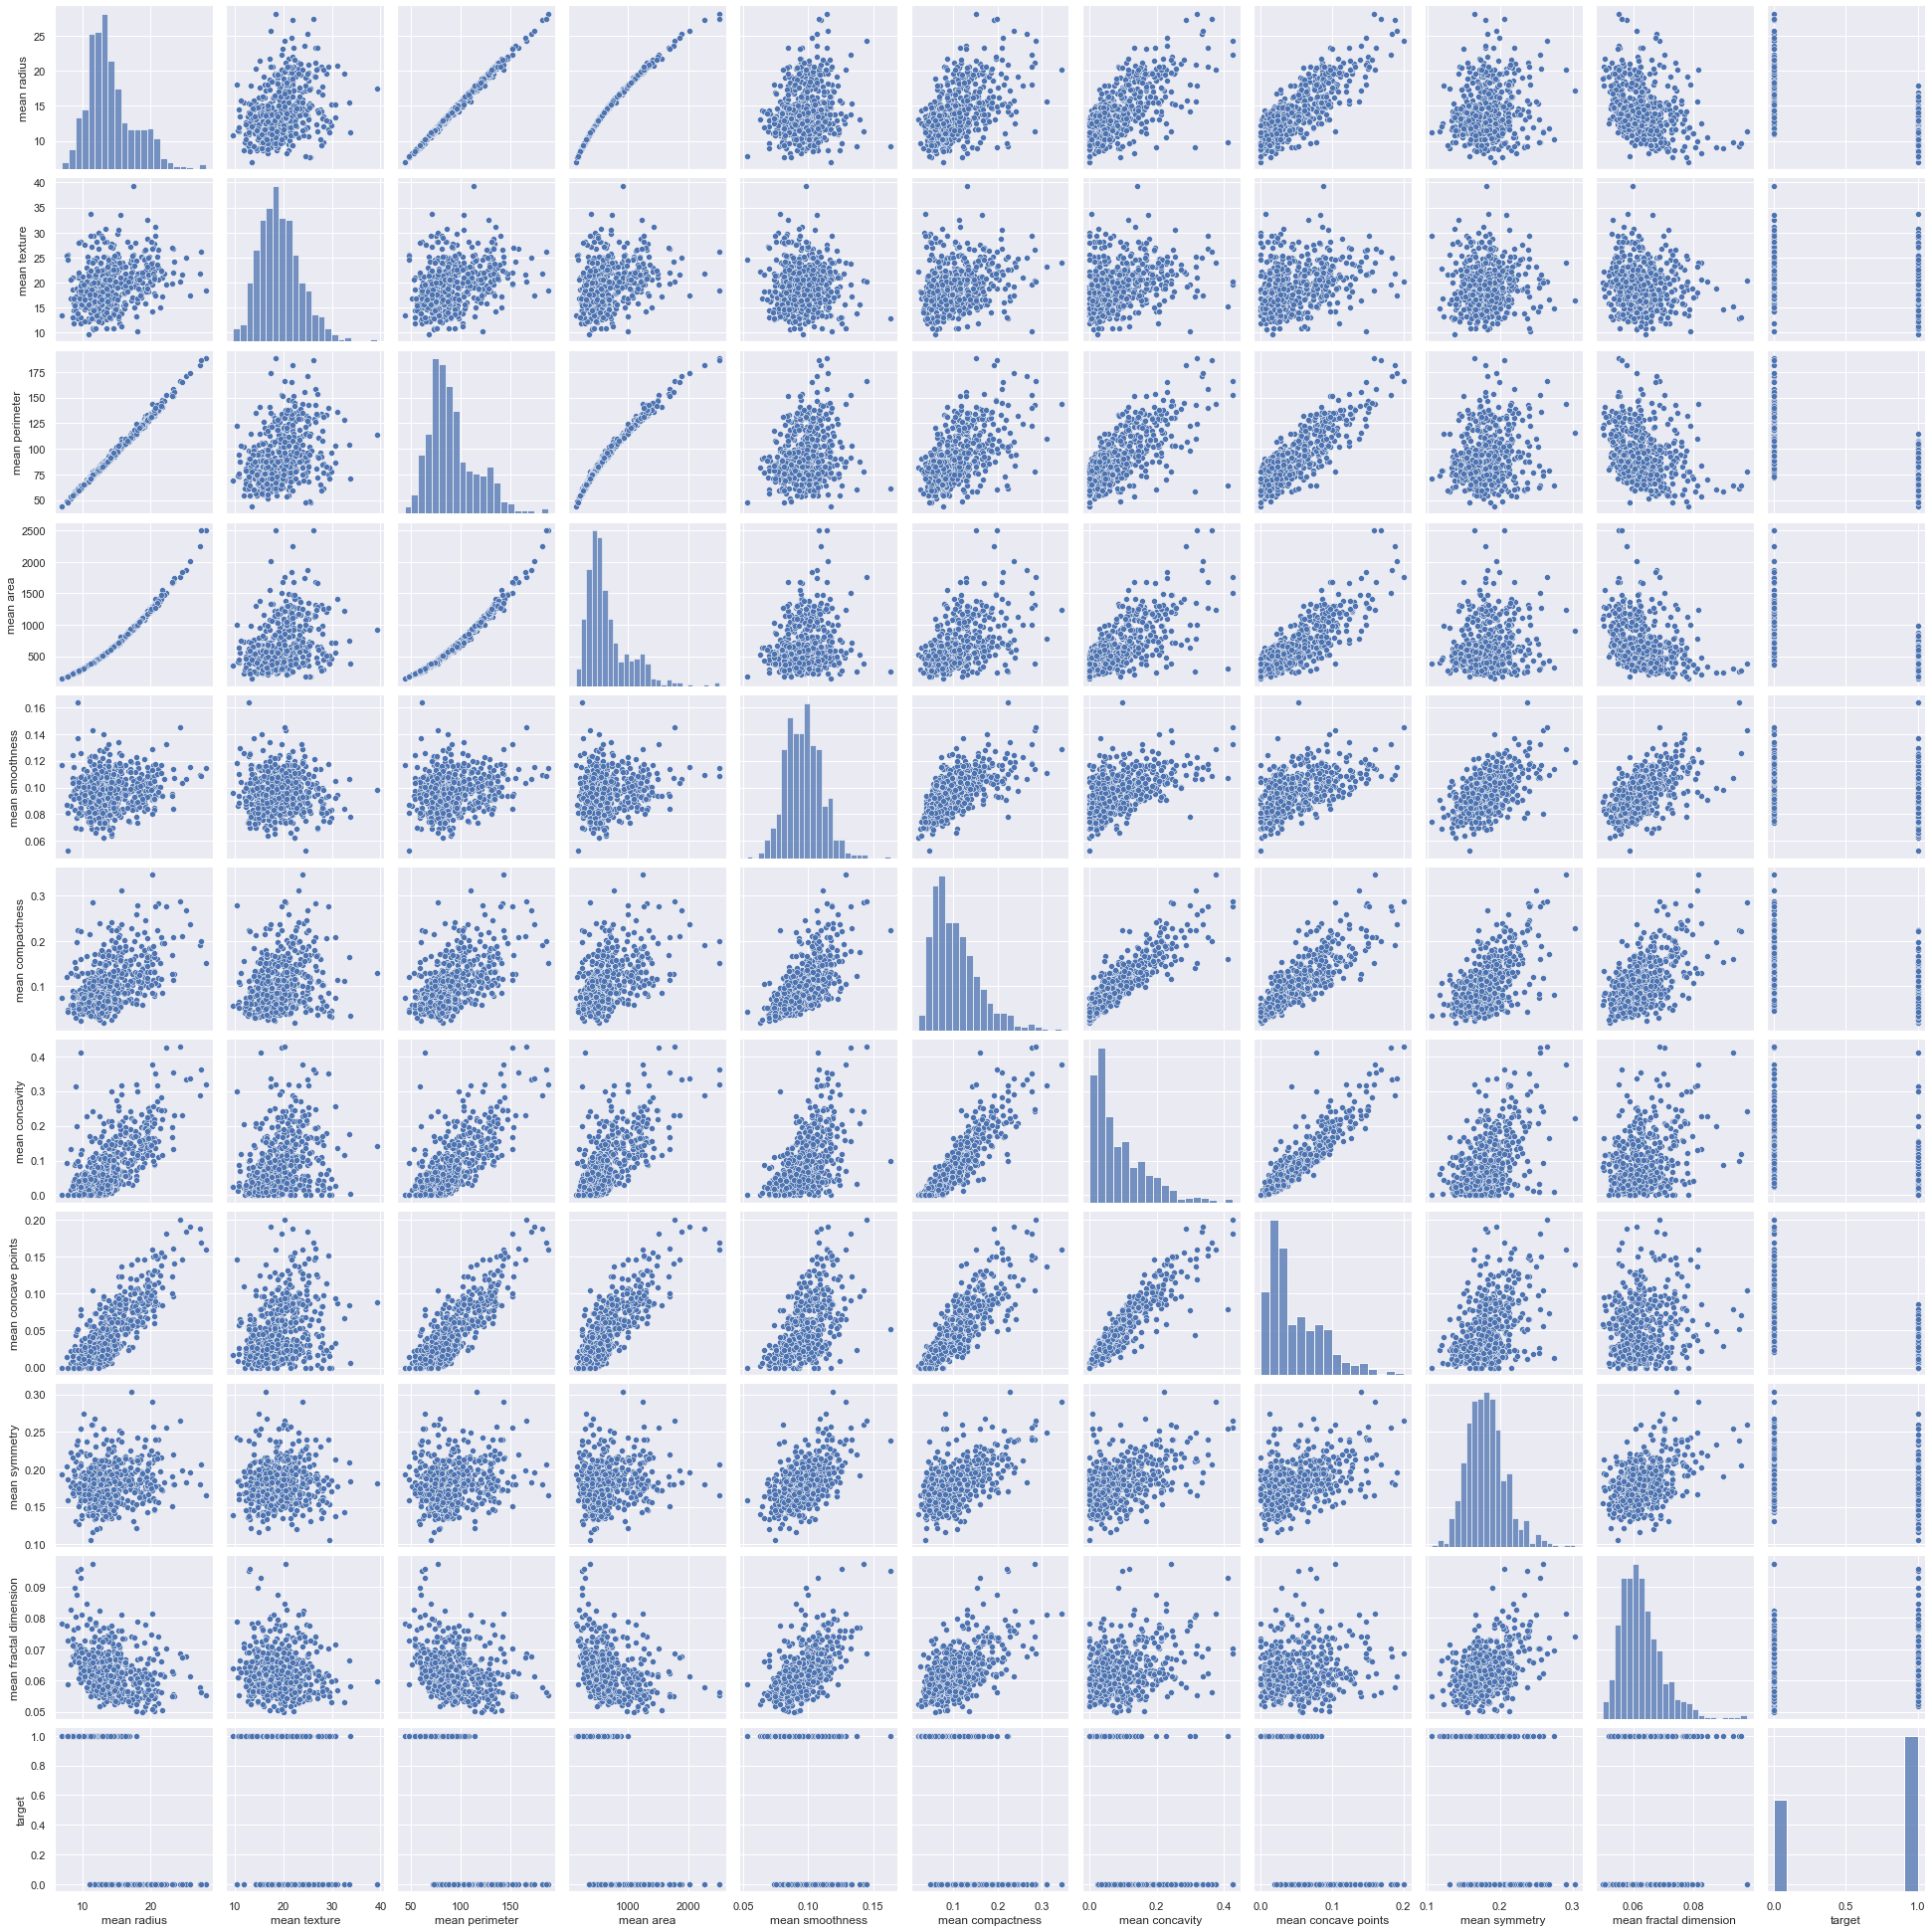

In [9]:
sns.pairplot(df)

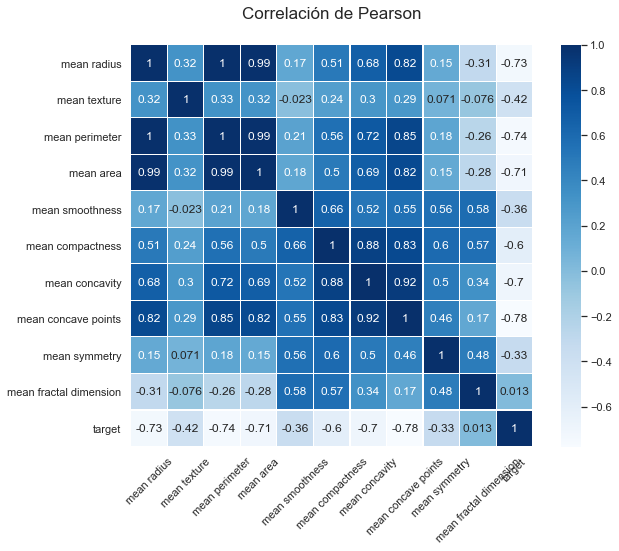

In [26]:
corr = df.corr()
plt.figure(figsize=(10,10))
plt.subplot2grid((4,3),(0,0),rowspan = 3, colspan = 3 )
sns.heatmap(corr,linewidths=0.1,vmax=1.0, square=True, cmap='Blues', linecolor='white', annot=True)
plt.title('Correlación de Pearson', y=1.05, size=17)
plt.xticks(rotation = 45)
plt.show()

### Ajuste de los modelos

In [27]:
# X = df.drop(columns = ['target'])
# 1. Varibales preditoras y variable a predecir
# Se toman solo 3 features del dataset

X = df[['mean radius','mean smoothness', 'mean concave points']] 
y = df['target']

In [28]:
# Se procede a reescalar los datos

from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
X = scl.fit_transform(X)

In [29]:
# 2. Separación de datos
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)

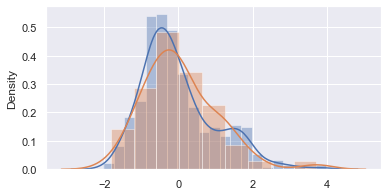

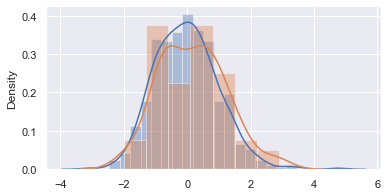

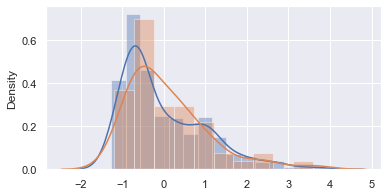

In [30]:
# Visualización de los datos
for i in range(X_train.shape[1]):
    plt.figure(figsize=(6,3))
    sns.distplot(X_train[:,i])
    sns.distplot(X_test[:,i])
    plt.show()

Se revisa la proporción de cada clase en las etiquetas en ambos conjuntos de datos.

In [31]:
print('Proporción de etiquetas positiva en datos de Train: ', y_train.sum()/y_train.size)
print('Proporción de etiquetas positiva en datos de Test: ', y_test.sum()/y_test.size)

Proporción de etiquetas positiva en datos de Train:  0.630859375
Proporción de etiquetas positiva en datos de Test:  0.5964912280701754


**Para investigar:** qué sucrede si la proporcición no es parecida? ¿Qué se debería hacer? 
Se recomienda investigar el parámetro `stratify` de la función `train_test_split()`.

Se sugiere ver al final de este notebook la nota de **datos desbalanceados**.

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Árbol de decisión

# 3. Instanciar el modelo
tree = DecisionTreeClassifier(max_depth = None)
# 4. Entrenar
tree.fit(X_train, y_train)
# 5. Predecir
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
# 6. Evaluar
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.8947368421052632


In [33]:
# KNN
# 3. Instanciar el modelo
knn = KNeighborsClassifier(n_neighbors=1)
# 4. Entrenar
knn.fit(X_train, y_train)
# 5. Predecir
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)
# 6. Evaluar
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.8771929824561403


Hay que elegir una métrica de rendimiento del modelo. Esto va a depender del problema y de si es una clasificación o una regresión.

Se recomienda que las métricas tengan análisis numérico y también el análisis gráfico de los errores.

### Cross Validation

La validación cruzada es un ejercicio que consiste en evaluar el desempeño del modelo en espaciósn diferenciados y repartidos por todo el datset. Resultan diferentes score por cada tramo.
Entre 5 y 10 folds es una separación que genera un buen score, un score robusto.

In [34]:
# CV para el Modelo KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate

cross_validate(KNeighborsClassifier(n_neighbors=1),X,y,return_train_score=True,cv=5)

{'fit_time': array([0.00075173, 0.00099683, 0.0010221 , 0.00099778, 0.00099635]),
 'score_time': array([0.00397873, 0.00398874, 0.00396538, 0.00299215, 0.00399518]),
 'test_score': array([0.87719298, 0.88596491, 0.87719298, 0.92105263, 0.89380531]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [35]:
results = cross_validate(KNeighborsClassifier(n_neighbors=1),X,y,return_train_score=True,cv=5)
test_scores = results['test_score']
train_scores = results['train_score']
print(np.mean(train_scores))
print(np.mean(test_scores))

1.0
0.8910417637012886


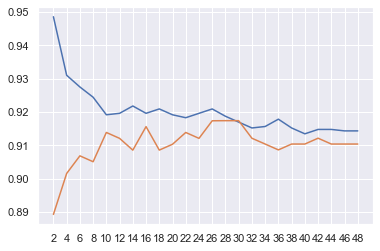

In [36]:
# Curvas ROC para KNN

# De forma más sistemática

# Curva de validación
n=np.arange(2,50,2)

from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(KNeighborsClassifier(),
                                           X,
                                           y,
                                           param_name='n_neighbors',
                                           param_range=n,
                                             cv=5)

plt.plot(np.mean(train_scores,axis=1))
plt.plot(np.mean(test_scores,axis=1))
plt.xticks(np.arange(24),n);

Interpretación: A pesar de que el score mejore, hay mucho techo y sigue habiendo un problema de varianza. La idea de la curva de validación es ayudar a simplificar o hacer más complejo el modelo, según se necesite.

En Lasso está el alpha, que le da más o menos libertad al modelo de buscar ciertos parámetros para entrenarse. De forma general se puede decir que mientras más se aumente, más simple. Mientras más se reduce, más complejo.

### Ahora vamos a revisar la curva de aprendizaje

In [37]:
from sklearn.model_selection import learning_curve

learning_curve(KNeighborsClassifier(n_neighbors=30),X,y,cv=5)

(array([ 45, 147, 250, 352, 455]),
 array([[0.91111111, 0.91111111, 0.91111111, 0.91111111, 0.91111111],
        [0.93877551, 0.87755102, 0.89115646, 0.89115646, 0.89115646],
        [0.94      , 0.896     , 0.916     , 0.9       , 0.9       ],
        [0.94034091, 0.91761364, 0.92045455, 0.91761364, 0.91761364],
        [0.92747253, 0.91208791, 0.90769231, 0.91648352, 0.92087912]]),
 array([[0.37719298, 0.37719298, 0.36842105, 0.36842105, 0.37168142],
        [0.86842105, 0.93859649, 0.92105263, 0.92982456, 0.86725664],
        [0.87719298, 0.94736842, 0.93859649, 0.92982456, 0.89380531],
        [0.85964912, 0.94736842, 0.92982456, 0.93859649, 0.89380531],
        [0.87719298, 0.93859649, 0.92982456, 0.92982456, 0.91150442]]))

La primera línea muestra con cuántos datos se entrenó el modelo.

Lo que hace esta curva (curva de aprendizaje) es mostrar si el score va mejorando, lo cual permite saber que el modelo está aprendiendo. Mientras más mejora el score en función de la cantidad de datos, esto es lo que verdaderamente se llama aprender.

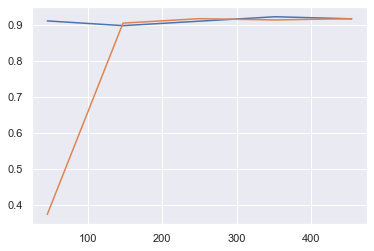

In [39]:
lc = learning_curve(KNeighborsClassifier(n_neighbors=30),X,y,cv=5)
samples, train, test = lc[0], lc[1], lc[2]

plt.plot(samples,np.mean(train,axis=1))
plt.plot(samples,np.mean(test,axis=1));

Dado que el primer valor del R2 es muy malo (viendo la curva naranja). Se elimina ese primer dato y se hace zoom.

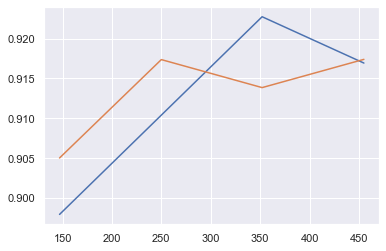

In [40]:
plt.plot(samples[1:],np.mean(train,axis=1)[1:])
plt.plot(samples[1:],np.mean(test,axis=1)[1:]);

Las curvas de validación y las curvas de aprendizaje son herramientas para un mejor diagnóstico.

Interpretación: hay diferencias significativas en R2. El modelo KNN está aprendiendo, pero no ha terminado de aprender. La curva naranja (validation score) debería ser una asíntota creciente, acercándose a un límite. Cuando esto sucede, se puede decir que el modelo no aprende más. Pero en este caso, al analizar la curva pareciera que el modelo está aprendiendo y se le pudiera agregar más datos para mejorar su desempeño.

De forma general también se puede comentar que KNN es un muy buen modelo de clasificación, pero cae fácilmente en la maldición de la dimensionalidad. Por eso no es factible aplicarlo en todos los problemas. Ejemplo: modelos con alta dimensionalidad y no muchos datos.

### Conceptos de optimización de hiperparámetros

Hay diversos métodos para la optimización de hiperparámetros. Además de las prácticas de optimización "manual", es posible encontrar mejores hiperparámetros usando: Random Search, GridSearch, Descenso por gradiente y Optimización Bayesiana. Es una buena práctica que las búsquedas de mejores hiperparámetros estén acompañadas de validación cruzada.



Documentación de `GridSearchCV()` [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Documentación de `RandomizedSearchCV()`[aquí](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

Si bien de forma general se busca maximizar accuracy, cuando se realiza optimización de hiperparámetros es recomendable evaluar con varias métricas: precisión, exhaustividad, F-Score y AUC-ROC, entre otras.

Adicional considerar que dependiendo del modelo que se está evaluando, las variables que se exploran son diferentes. Ejemplo: variables que pueden ser interesantes de explorar en el caso de un árbol de decisión: `criterion`, `max_depth`, `min_samples_split` y `min_samples_leaf`.
Para este mismo caso (árbol de decisión) hay 3 atributos del modelo (clase de la librería sklearn) que se usan para encontrar la mejor configuración, el mejor performance y el resto de resultados. Los atributos son: `best_params_`, `best_score_` y `cv_results_`.

### Conceptos adicionales

Overfitting (sobreajuste) y Underfitting (subajuste): ambos son condiciones nos  deseadas de los modelos que se identifican al querer generalizar.

![alt text](Pic.JPG)

De forma general se puede decir que un sesgo (bias) alto tiene que ver con underfitting; varianza alta con overfitting.

### Cómo solucionar el Overfitting y el Underfitting

Si se presenta Varianza alta, se recomienda:
+ Conseguir más ejemplos
+ Reducir la cantidad de features
+ Aumentar coeficiente de regularización (hacer el modelo más simple. Ej: en Lasso cuando aumentamos el alpha)

Si se presenta Bias alto, se recomienda:
+ Más features
+ Modelos más complejos

De forma general se puede decir que un modelo simple tiende a tener un sesgo algo. Un modelo complejo tiende a tener una varianza alta. Siempre es importante dignósticar en cuál de esos casos se está. Una vez identificado, hay que tratar de corregir eligiendo bien los parámetros del modelo o eligiendo otro modelo.

Si se percibe que hay un mal resultado en general, se sugiere probar con otro algoritmo o familia de modelos. Quizás las hipótesis del modelo no son cumplidas por el conjunto de datos.

### Métricas y evaluación

Para tener mayor profundidad en las métricas de evaluación, se sugiere explorar la [documentación](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

Un conjunto de métricas importantes son las derivadas de matriz de confusión. Se recomienda este [artículo](https://towardsdatascience.com/performance-metrics-confusion-matrix-precision-recall-and-f1-score-a8fe076a2262) que explica su con bastante profundidad. Adicional se recomienda tener claros los conceptos en inglés, dado que toda su documentación está en este idioma. Traducción de algunos conceptos:


<img src="Trad.JPG" alt="drawing" width="300"/>

### Datos no balanceados (o desbalanceados)

Desbalance de datos se da cuando la cantidad y el tipo de datos hace que haya una clase de la cual se tienen muy pocos datos. Por tal razón se genera un desbalance en los datos de entrenamiento del modelo. Ejemplo: en un dataset de pacientes con enfermedad y sin enefermedad, si hay muy pocos datos de pacientes con enfermedad, puede darse desbalanceo. También pasa en casos de detección de fraude, donde la cantidad de transacciones fraudulentas es generalmente baja en comparación con las transacciones normales. 

Con el fin de tener un buen desempeño de modelos, los análisis de datos desbalanceados suelen incluir técnicas como:
+ Generación de muestras sintéticas
+ Análisis de muestreo (oversampling, undersampling o weighting).
+ Stacking y Boosting
+ Cambiar (o usar otras) métricas de evaluación